## Part 1

Train shape: (150000, 12) | Test shape: (101503, 12)
Train columns: ['Unnamed: 0', 'SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

Default rate (mean target): 0.06684


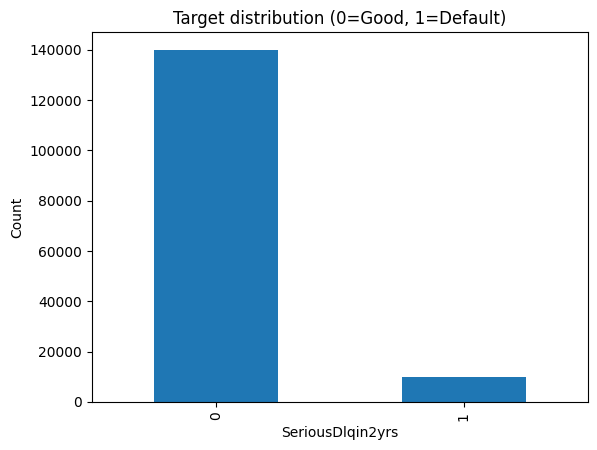


Top missingness (train):


,0
MonthlyIncome,0.198207
NumberOfDependents,0.026160
Unnamed: 0,0.000000
SeriousDlqin2yrs,0.000000
age,0.000000
RevolvingUtilizationOfUnsecuredLines,0.000000
DebtRatio,0.000000
NumberOfTime30-59DaysPastDueNotWorse,0.000000
NumberOfOpenCreditLinesAndLoans,0.000000
NumberOfTimes90DaysLate,0.000000


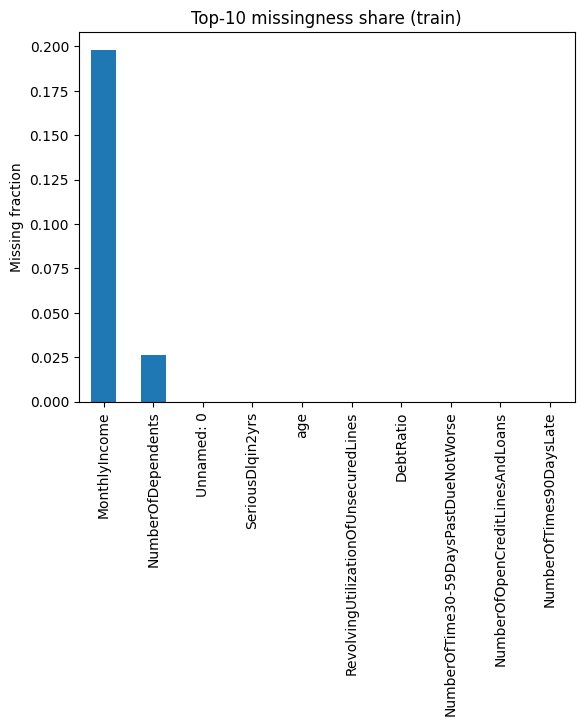

,count,mean,std,min,25%,50%,75%,max
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0
NumberOfDependents,146076.0,0.757222,1.115086,0.0,0.000000,0.000000,1.000000,20.0


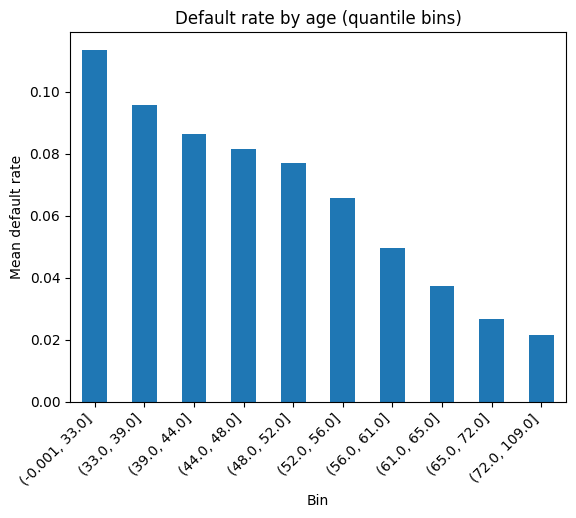

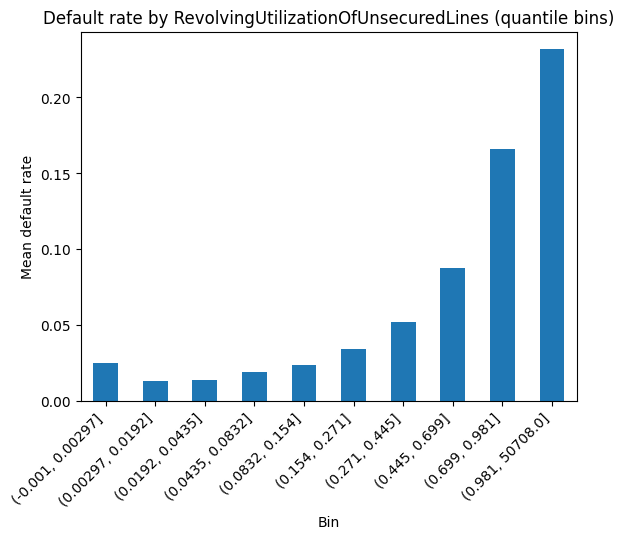

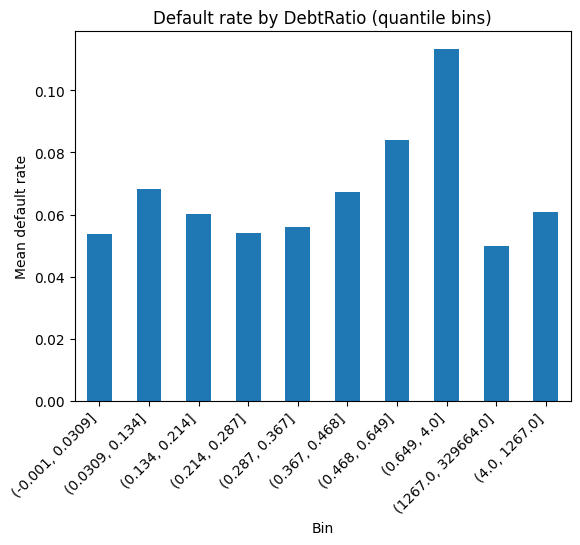

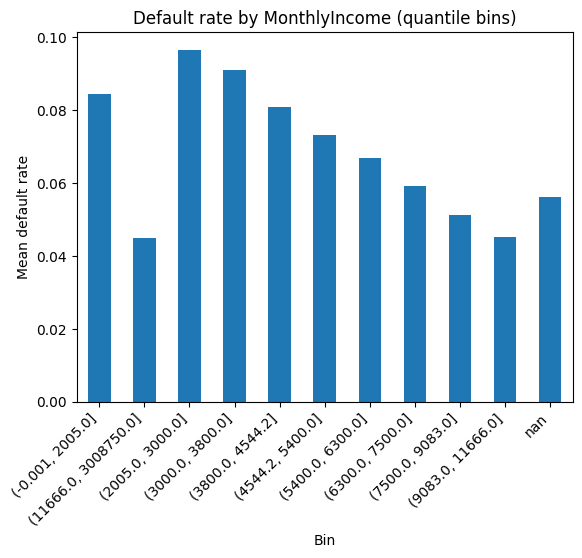

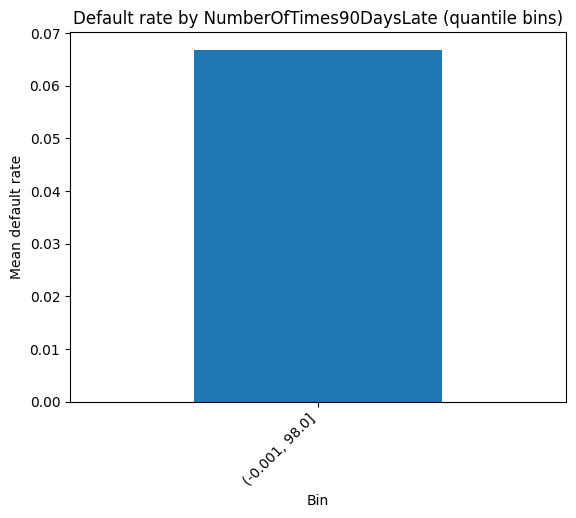

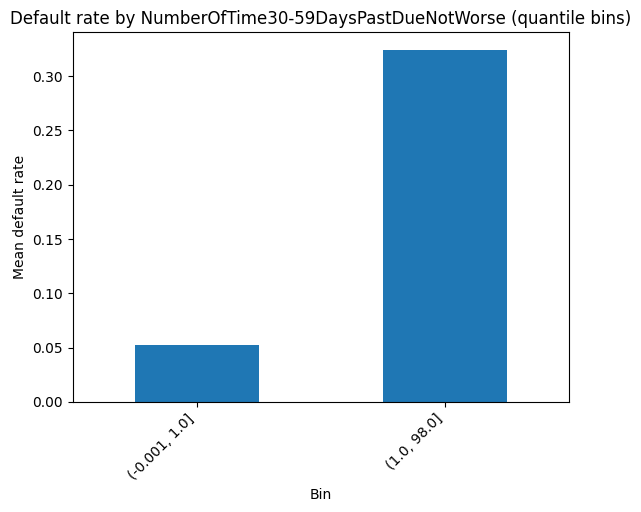

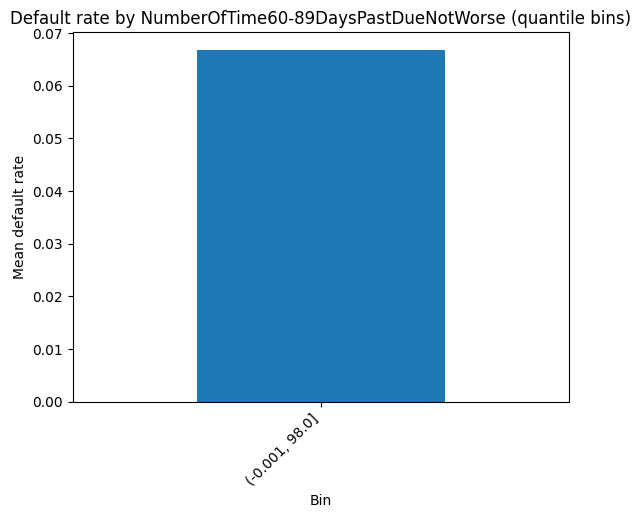


EDA conclusions (to include in report/notebook text):
1) Target is imbalanced (~6–7% defaults): use stratified split and consider class-weight / sampling.
2) MonthlyIncome has ~20% missing values; NumberOfDependents ~2–3% missing → must be imputed.
3) Delinquency counts (30-59 / 60-89 / 90+) and utilization are the strongest risk signals (default-rate rises sharply).
4) Age is inversely related to default risk in this dataset (younger applicants default more often).
5) Some variables have extreme outliers (DebtRatio, Utilization, delinquency counts like 96/98) → cap/winsorize before binning.



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_train = pd.read_csv('cs-training.csv')
df_test  = pd.read_csv('cs-test.csv')

target = 'SeriousDlqin2yrs'
id_col = 'Unnamed: 0' if 'Unnamed: 0' in df_train.columns else 'id'

print("Train shape:", df_train.shape, "| Test shape:", df_test.shape)
print("Train columns:", df_train.columns.tolist())

y = df_train[target].astype(int)
print("\nDefault rate (mean target):", round(y.mean(), 5))

plt.figure()
y.value_counts().sort_index().plot(kind='bar')
plt.title('Target distribution (0=Good, 1=Default)')
plt.xlabel('SeriousDlqin2yrs')
plt.ylabel('Count')
plt.show()

miss_train = df_train.isna().mean().sort_values(ascending=False)
miss_test  = df_test.isna().mean().sort_values(ascending=False)

print("\nTop missingness (train):")
display(miss_train.head(10))

plt.figure()
miss_train.head(10).plot(kind='bar')
plt.title('Top-10 missingness share (train)')
plt.ylabel('Missing fraction')
plt.show()

num_cols = [c for c in df_train.columns if c not in [target, id_col]]
display(df_train[num_cols].describe().T)

def plot_default_rate_by_quantile(df, col, q=10):
    x = pd.to_numeric(df[col], errors='coerce')
    bins = pd.qcut(x, q=q, duplicates='drop')
    tmp = pd.DataFrame({'bin': bins.astype(str), 'y': df[target].astype(int)})
    rate = tmp.groupby('bin', observed=True)['y'].mean()
    plt.figure()
    rate.plot(kind='bar')
    plt.title(f'Default rate by {col} (quantile bins)')
    plt.xlabel('Bin')
    plt.ylabel('Mean default rate')
    plt.xticks(rotation=45, ha='right')
    plt.show()

for c in [
    'age',
    'RevolvingUtilizationOfUnsecuredLines',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfTimes90DaysLate',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse'
]:
    if c in df_train.columns:
        plot_default_rate_by_quantile(df_train, c, q=10)

Train contains 150,000 observations (12 columns) and the target is strongly imbalanced: the default rate is about 6.7%. Missing values are concentrated mainly in MonthlyIncome (~19.8%) and to a smaller extent in NumberOfDependents (~2.6%), so these variables require imputation. Several features show extreme outliers (especially RevolvingUtilizationOfUnsecuredLines and DebtRatio), which should be capped/winsorized before WoE binning. The default rate decreases with age and increases with credit utilization and delinquency indicators, suggesting these are key risk drivers. Due to class imbalance, model evaluation should rely on metrics like ROC-AUC and include imbalance-handling techniques.

## Part 2


In [ ]:
import numpy as np
import pandas as pd

target = 'SeriousDlqin2yrs'
id_col = 'Unnamed: 0' if 'Unnamed: 0' in df_train.columns else 'id'

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df['age'] = pd.to_numeric(df['age'], errors='coerce').fillna(0).clip(lower=18)

    delin_cols = [
        'NumberOfTime30-59DaysPastDueNotWorse',
        'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfTimes90DaysLate'
    ]
    for c in delin_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0).clip(lower=0, upper=10)

    df['RevolvingUtilizationOfUnsecuredLines'] = (
        pd.to_numeric(df['RevolvingUtilizationOfUnsecuredLines'], errors='coerce')
          .fillna(0).clip(lower=0, upper=5)
    )

    df['DebtRatio'] = pd.to_numeric(df['DebtRatio'], errors='coerce').fillna(0).clip(lower=0)
    cap = df['DebtRatio'].quantile(0.999)
    df['DebtRatio'] = df['DebtRatio'].clip(upper=cap)

    df['MonthlyIncome'] = pd.to_numeric(df['MonthlyIncome'], errors='coerce')
    age_bins = pd.qcut(df['age'], q=10, duplicates='drop')
    inc_med = df.groupby(age_bins, observed=True)['MonthlyIncome'].median()
    df['MonthlyIncome'] = df['MonthlyIncome'].where(~df['MonthlyIncome'].isna(), age_bins.map(inc_med).astype(float))
    df['MonthlyIncome'] = df['MonthlyIncome'].fillna(df['MonthlyIncome'].median())

    df['NumberOfDependents'] = pd.to_numeric(df['NumberOfDependents'], errors='coerce').fillna(0).clip(lower=0)

    df['log_DebtRatio'] = np.log1p(df['DebtRatio'])
    df['log_Utilization'] = np.log1p(df['RevolvingUtilizationOfUnsecuredLines'])
    df['log_MonthlyIncome'] = np.log1p(df['MonthlyIncome'])
    df['log_OpenCreditLines'] = np.log1p(pd.to_numeric(df['NumberOfOpenCreditLinesAndLoans'], errors='coerce').fillna(0).clip(lower=0))

    df['TotalPastDueEvents'] = df[delin_cols].sum(axis=1)
    df['HasAnyPastDue'] = (df['TotalPastDueEvents'] > 0).astype(int)
    df['WeightedPastDue'] = (
        1*df['NumberOfTime30-59DaysPastDueNotWorse'] +
        2*df['NumberOfTime60-89DaysPastDueNotWorse'] +
        3*df['NumberOfTimes90DaysLate']
    )

    df['IncomePerDependent'] = df['MonthlyIncome'] / (1 + df['NumberOfDependents'])
    df['log_IncomePerDependent'] = np.log1p(df['IncomePerDependent'])

    df['DebtToIncomeProxy'] = df['DebtRatio'] / (1 + df['log_MonthlyIncome'])
    df['OpenLinesPerAge'] = pd.to_numeric(df['NumberOfOpenCreditLinesAndLoans'], errors='coerce').fillna(0) / df['age']
    df['RealEstateShare'] = (
        pd.to_numeric(df['NumberRealEstateLoansOrLines'], errors='coerce').fillna(0) /
        (1 + pd.to_numeric(df['NumberOfOpenCreditLinesAndLoans'], errors='coerce').fillna(0))
    )

    df.replace([np.inf, -np.inf], 0, inplace=True)
    df.fillna(0, inplace=True)
    return df

df_train_fe = add_features(df_train)
df_test_fe  = add_features(df_test)

print("After feature engineering:")
print("Train:", df_train_fe.shape, "Test:", df_test_fe.shape)

print("Max missing fraction (train_fe):", float(df_train_fe.isna().mean().max()))

After feature engineering:
Train: (150000, 24) Test: (101503, 24)
Max missing fraction (train_fe): 0.0


Feature engineering increased the dataset from the original fields to 24 columns for both train and test, adding several logical risk-related derived variables. After applying imputations and basic cleaning, the engineered training set has no missing values (max missing fraction = 0.0). These transformations prepare the data for stable WoE binning and improve interpretability by capturing aggregated delinquency and income/ratio effects.

## Part 3


In [ ]:
from sklearn.model_selection import train_test_split

target = 'SeriousDlqin2yrs'
id_col = 'Unnamed: 0' if 'Unnamed: 0' in df_train_fe.columns else 'id'

y = df_train_fe[target].astype(int)
X = df_train_fe.drop(columns=[target])

ids_train = X[id_col] if id_col in X.columns else None
X = X.drop(columns=[id_col]) if id_col in X.columns else X

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Train split:", X_train_raw.shape, "Val split:", X_val_raw.shape)
print("Default rate train:", round(y_train.mean(),5), "val:", round(y_val.mean(),5))

Train split: (112500, 22) Val split: (37500, 22)
Default rate train: 0.06684 val: 0.06683


,feature,IV
16,WeightedPastDue,1.357651
0,RevolvingUtilizationOfUnsecuredLines,1.135386
14,TotalPastDueEvents,1.102441
11,log_Utilization,1.098804
2,NumberOfTime30-59DaysPastDueNotWorse,0.481704
6,NumberOfTimes90DaysLate,0.480529
8,NumberOfTime60-89DaysPastDueNotWorse,0.258384
1,age,0.241842
18,log_IncomePerDependent,0.108555
17,IncomePerDependent,0.108537


WOE shapes: (112500, 22) (37500, 22)


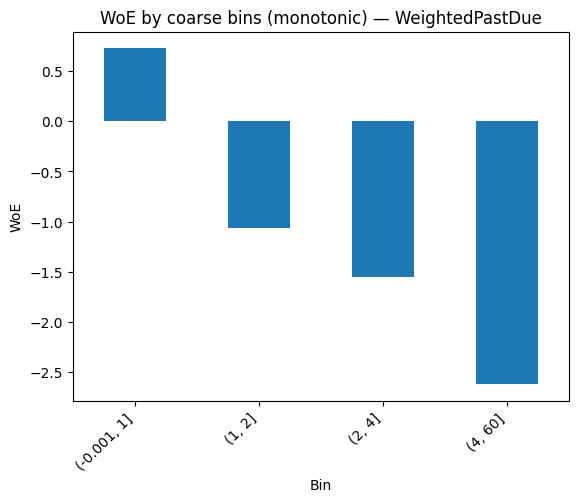

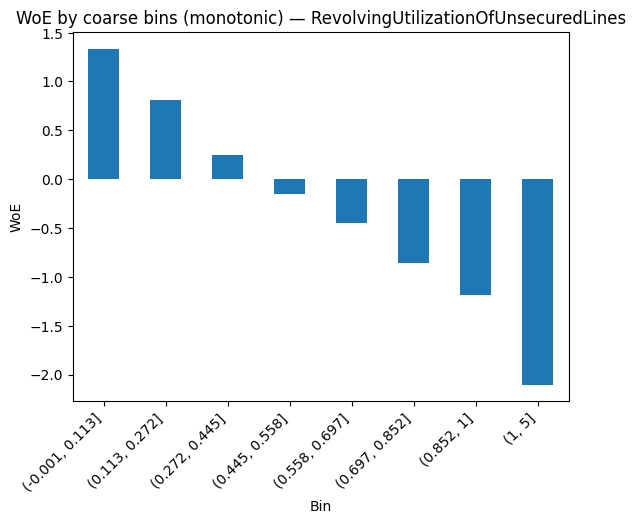

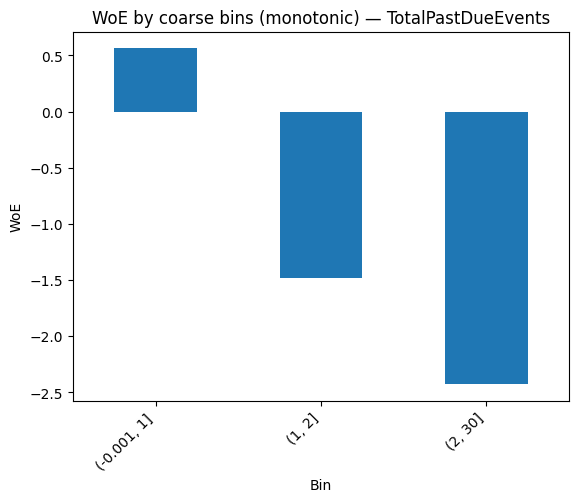

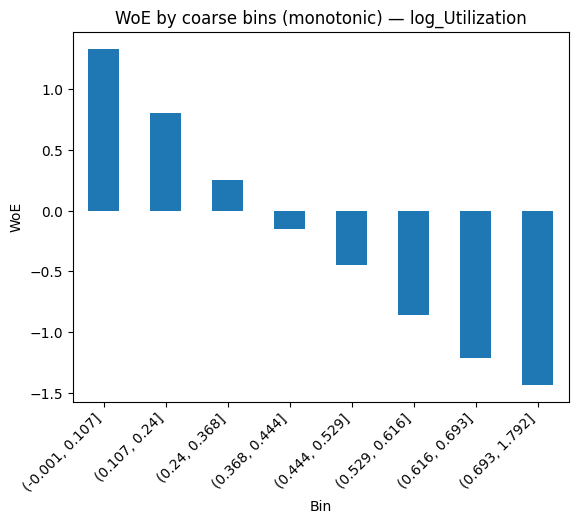

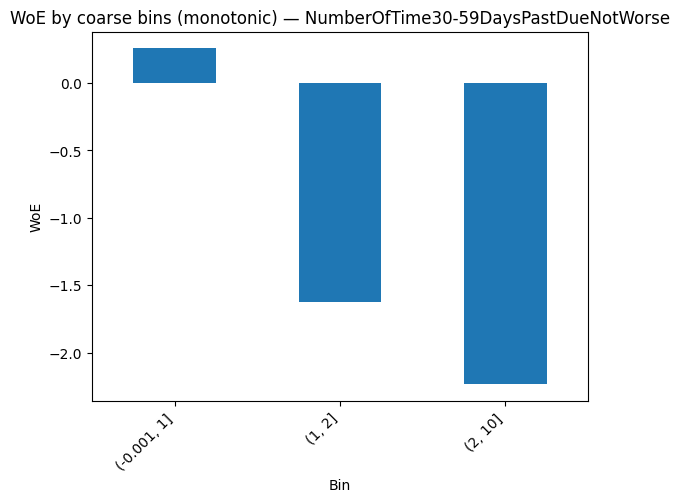

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

EPS = 1e-6

def _calc_woe_table(bins: pd.Series, y: pd.Series, eps=EPS):
    tmp = pd.DataFrame({'bin': bins, 'y': y})
    g = tmp.groupby('bin', observed=True)['y']
    bad = g.sum().astype(float)
    cnt = g.count().astype(float)
    good = cnt - bad

    bad_dist = bad / (bad.sum() + eps)
    good_dist = good / (good.sum() + eps)

    woe = np.log((good_dist + eps) / (bad_dist + eps))
    iv = ((good_dist - bad_dist) * woe).sum()

    out = pd.DataFrame({
        'count': cnt,
        'bad': bad,
        'good': good,
        'bad_rate': bad / cnt,
        'woe': woe
    }).sort_index()
    return out, float(iv)

def fine_binning_numeric(x: pd.Series, n_bins=20):
    x = pd.to_numeric(x, errors='coerce')
    mask = x.notna()
    try:
        b = pd.qcut(x[mask], q=n_bins, duplicates='drop')
    except ValueError:
        b = pd.cut(x[mask], bins=n_bins)

    intervals = b.cat.categories
    labels = intervals.astype(str).tolist()

    lab_full = pd.Series(index=x.index, dtype='object')
    lab_full.loc[mask] = b.astype(str).values
    lab_full.loc[~mask] = 'MISSING'

    categories = labels + ['MISSING']
    cat_full = pd.Categorical(lab_full, categories=categories, ordered=True)
    return cat_full, intervals, categories

def coarse_monotonic_binning(x: pd.Series, y: pd.Series, n_fine=20, max_bins=8, eps=EPS):
    fine_cat, intervals, categories = fine_binning_numeric(x, n_fine)
    fine_s = pd.Series(fine_cat, index=x.index).astype(str)

    non_missing = [c for c in categories if c != 'MISSING']
    groups = [[c] for c in non_missing]

    def group_assign(labels, groups):
        mapping = {}
        for gi, g in enumerate(groups):
            glabel = f'bin_{gi:02d}'
            for c in g:
                mapping[c] = glabel
        return labels.map(mapping)

    def group_woe(grp):
        tab = pd.crosstab(grp, y)
        if 0 not in tab.columns: tab[0] = 0
        if 1 not in tab.columns: tab[1] = 0
        good = tab[0].astype(float)
        bad  = tab[1].astype(float)
        good_dist = good/(good.sum()+eps)
        bad_dist  = bad /(bad.sum()+eps)
        woe = np.log((good_dist+eps)/(bad_dist+eps))
        return woe.sort_index()

    while True:
        grp = group_assign(fine_s, groups)
        w = group_woe(grp.dropna())
        wv = w.values
        idx = np.arange(len(wv))
        corr = spearmanr(idx, wv).correlation
        increasing = True if (corr is None or np.isnan(corr) or corr >= 0) else False

        violation = None
        for i in range(len(wv) - 1):
            if increasing and (wv[i] > wv[i+1] + 1e-12):
                violation = i; break
            if (not increasing) and (wv[i] < wv[i+1] - 1e-12):
                violation = i; break

        if violation is None and len(groups) <= max_bins:
            break

        if violation is None:
            diffs = np.abs(np.diff(wv))
            merge_i = int(np.argmin(diffs))
        else:
            merge_i = violation

        groups[merge_i] = groups[merge_i] + groups[merge_i+1]
        del groups[merge_i+1]
        if len(groups) == 1:
            break

    cat_to_idx = {c:i for i,c in enumerate(non_missing)}
    group_idxs = [sorted([cat_to_idx[c] for c in g]) for g in groups]

    edges = [float(intervals[group_idxs[0][0]].left)]
    labels = []
    for lst in group_idxs:
        left = float(intervals[lst[0]].left)
        right = float(intervals[lst[-1]].right)
        edges.append(right)
        labels.append(f'({left:.6g}, {right:.6g}]')

    def apply_bins(x_new):
        x_new = pd.to_numeric(x_new, errors='coerce')
        b = pd.cut(x_new, bins=edges, include_lowest=True, right=True)
        lab = b.astype(str).where(~x_new.isna(), 'MISSING')

        cats = pd.cut(x_new.dropna(), bins=edges, include_lowest=True, right=True).cat.categories
        cut_labels = cats.astype(str).tolist()
        mapping = {cut_labels[i]: labels[i] for i in range(len(labels))}
        return lab.replace(mapping)

    coarse_lab = apply_bins(x)
    woe_table, iv = _calc_woe_table(coarse_lab, y)

    return {
        'edges': edges,
        'labels': labels,
        'woe_map': woe_table['woe'].to_dict(),
        'iv': iv,
        'increasing': increasing
    }

def transform_woe(df: pd.DataFrame, binnings: dict):
    out = pd.DataFrame(index=df.index)
    for col, b in binnings.items():
        x = pd.to_numeric(df[col], errors='coerce')
        cut = pd.cut(x, bins=b['edges'], include_lowest=True, right=True)
        lab = cut.astype(str).where(~x.isna(), 'MISSING')

        cats = pd.cut(x.dropna(), bins=b['edges'], include_lowest=True, right=True).cat.categories
        cut_labels = cats.astype(str).tolist()
        mapping = {cut_labels[i]: b['labels'][i] for i in range(len(b['labels']))}
        lab = lab.replace(mapping)

        out[col + '_woe'] = lab.map(b['woe_map']).fillna(0.0).astype(float)
    return out

binnings = {}
iv_list = []
for col in X_train_raw.columns:
    binfo = coarse_monotonic_binning(X_train_raw[col], y_train, n_fine=20, max_bins=8)
    binnings[col] = binfo
    iv_list.append((col, binfo['iv']))

iv_df = pd.DataFrame(iv_list, columns=['feature', 'IV']).sort_values('IV', ascending=False)
display(iv_df.head(15))

X_train_woe = transform_woe(X_train_raw, binnings)
X_val_woe   = transform_woe(X_val_raw, binnings)

print("WOE shapes:", X_train_woe.shape, X_val_woe.shape)

top_vars = iv_df.head(5)['feature'].tolist()
for v in top_vars:
    x = pd.to_numeric(X_train_raw[v], errors='coerce')
    cut = pd.cut(x, bins=binnings[v]['edges'], include_lowest=True, right=True)
    lab = cut.astype(str).where(~x.isna(), 'MISSING')

    cats = pd.cut(x.dropna(), bins=binnings[v]['edges'], include_lowest=True, right=True).cat.categories
    cut_labels = cats.astype(str).tolist()
    mapping = {cut_labels[i]: binnings[v]['labels'][i] for i in range(len(binnings[v]['labels']))}
    lab = lab.replace(mapping)

    woe_tbl, _ = _calc_woe_table(lab, y_train)

    plt.figure()
    woe_tbl['woe'].plot(kind='bar')
    plt.title(f'WoE by coarse bins (monotonic) — {v}')
    plt.xlabel('Bin')
    plt.ylabel('WoE')
    plt.xticks(rotation=45, ha='right')
    plt.show()

Validation ROC-AUC: 0.856174


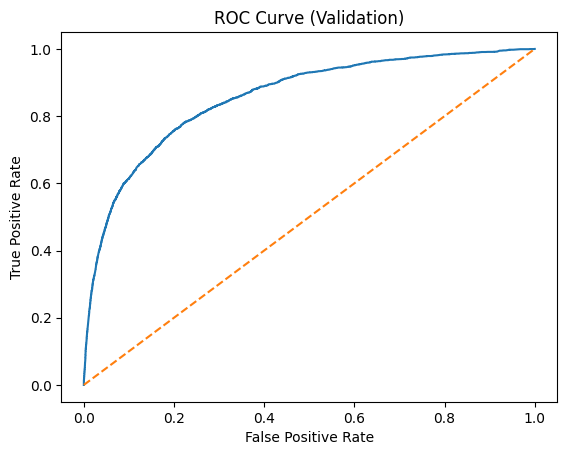

              precision    recall  f1-score   support

           0     0.9466    0.9877    0.9668     34994
           1     0.5653    0.2227    0.3195      2506

    accuracy                         0.9366     37500
   macro avg     0.7560    0.6052    0.6431     37500
weighted avg     0.9212    0.9366    0.9235     37500



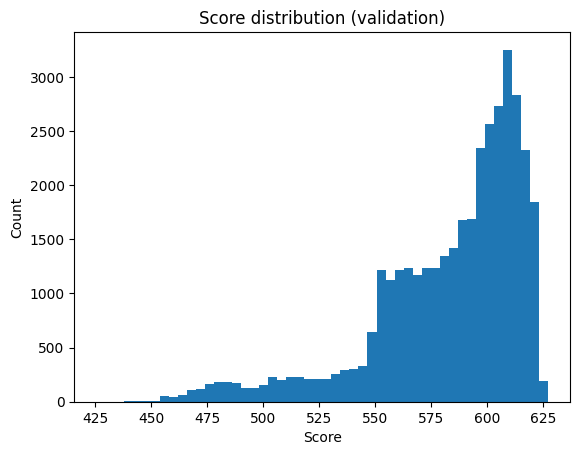

Score summary (val):
count    37500.000000
mean       583.343708
std         33.755955
min        425.707963
25%        565.777998
50%        593.479016
75%        608.501315
max        627.291988
dtype: float64


,feature,bin,woe,coef,points
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.113]",1.335893,-0.650092,25.058251
1,RevolvingUtilizationOfUnsecuredLines,"(0.113, 0.272]",0.806941,-0.650092,15.136343
2,RevolvingUtilizationOfUnsecuredLines,"(0.272, 0.445]",0.250599,-0.650092,4.700652
3,RevolvingUtilizationOfUnsecuredLines,"(0.445, 0.558]",-0.149741,-0.650092,-2.808802
4,RevolvingUtilizationOfUnsecuredLines,"(0.558, 0.697]",-0.448208,-0.650092,-8.407346
5,RevolvingUtilizationOfUnsecuredLines,"(0.697, 0.852]",-0.855771,-0.650092,-16.052276
6,RevolvingUtilizationOfUnsecuredLines,"(0.852, 1]",-1.186698,-0.650092,-22.259701
7,RevolvingUtilizationOfUnsecuredLines,"(1, 5]",-2.103740,-0.650092,-39.461279
8,age,"(17.999, 33]",-0.553156,-0.317173,-5.062306
9,age,"(33, 52]",-0.258341,-0.317173,-2.364256


Base points (intercept part): 562.8133


,feature,PSI
3,DebtRatio,0.007365
19,DebtToIncomeProxy,0.000606
4,MonthlyIncome,0.000248
18,log_IncomePerDependent,0.000218
17,IncomePerDependent,0.000215
0,RevolvingUtilizationOfUnsecuredLines,0.000202
1,age,0.000176
9,NumberOfDependents,0.000165
11,log_Utilization,0.000164
12,log_MonthlyIncome,0.000149



PSI interpretation (rule-of-thumb):
- PSI < 0.10 : no significant shift
- 0.10–0.25  : moderate shift (watch)
- > 0.25     : major shift (investigate)

PSI for SCORE (val vs test): 0.000388


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

lr = LogisticRegression(max_iter=4000, solver='lbfgs')
lr.fit(X_train_woe, y_train)

p_val = lr.predict_proba(X_val_woe)[:, 1]
auc = roc_auc_score(y_val, p_val)
print("Validation ROC-AUC:", round(auc, 6))

fpr, tpr, thr = roc_curve(y_val, p_val)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.title('ROC Curve (Validation)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

pred05 = (p_val >= 0.5).astype(int)
print(classification_report(y_val, pred05, digits=4))

PDO = 20
TARGET_SCORE = 600
TARGET_ODDS = 50

Factor = PDO / np.log(2)
Offset = TARGET_SCORE - Factor * np.log(TARGET_ODDS)

beta = pd.Series(lr.coef_[0], index=X_train_woe.columns)
alpha = float(lr.intercept_[0])

def score_from_woe(Xw: pd.DataFrame) -> np.ndarray:
    logit_bad = alpha + Xw.values @ beta.values
    log_odds_good_bad = -logit_bad
    score = Offset + Factor * log_odds_good_bad
    return score

val_score = score_from_woe(X_val_woe)
plt.figure()
plt.hist(val_score, bins=50)
plt.title("Score distribution (validation)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

print("Score summary (val):")
print(pd.Series(val_score).describe())

scorecard_rows = []
for raw_col in X_train_raw.columns:
    woe_col = raw_col + '_woe'
    coef = float(beta[woe_col])

    edges = binnings[raw_col]['edges']
    labels = binnings[raw_col]['labels']
    wmap = binnings[raw_col]['woe_map']

    for lab in labels:
        w = float(wmap.get(lab, 0.0))
        points = -Factor * coef * w
        scorecard_rows.append([raw_col, lab, w, coef, points])

    if 'MISSING' in wmap:
        w = float(wmap['MISSING'])
        points = -Factor * coef * w
        scorecard_rows.append([raw_col, 'MISSING', w, coef, points])

scorecard = pd.DataFrame(scorecard_rows, columns=['feature', 'bin', 'woe', 'coef', 'points'])
display(scorecard.head(30))

base_points = Offset - Factor * alpha
print("Base points (intercept part):", round(base_points, 4))

def psi(expected_perc, actual_perc, eps=1e-6):
    expected_perc = np.clip(expected_perc, eps, 1)
    actual_perc   = np.clip(actual_perc, eps, 1)
    return np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))

def psi_for_feature(train_series_bins: pd.Series, test_series_bins: pd.Series):
    all_bins = sorted(set(train_series_bins.unique()) | set(test_series_bins.unique()))
    tr = train_series_bins.value_counts(normalize=True).reindex(all_bins, fill_value=0).values
    te = test_series_bins.value_counts(normalize=True).reindex(all_bins, fill_value=0).values
    return float(psi(tr, te))

X_test_raw = df_test_fe.drop(columns=[target])
ids_test = X_test_raw[id_col] if id_col in X_test_raw.columns else None
X_test_raw = X_test_raw.drop(columns=[id_col]) if id_col in X_test_raw.columns else X_test_raw

X_test_woe = transform_woe(X_test_raw, binnings)

psi_rows = []
for raw_col in X_train_raw.columns:
    xtr = pd.to_numeric(X_train_raw[raw_col], errors='coerce')
    xte = pd.to_numeric(X_test_raw[raw_col], errors='coerce')

    cut_tr = pd.cut(xtr, bins=binnings[raw_col]['edges'], include_lowest=True, right=True).astype(str).where(~xtr.isna(), 'MISSING')
    cut_te = pd.cut(xte, bins=binnings[raw_col]['edges'], include_lowest=True, right=True).astype(str).where(~xte.isna(), 'MISSING')

    cats = pd.cut(xtr.dropna(), bins=binnings[raw_col]['edges'], include_lowest=True, right=True).cat.categories
    cut_labels = cats.astype(str).tolist()
    mapping = {cut_labels[i]: binnings[raw_col]['labels'][i] for i in range(len(binnings[raw_col]['labels']))}
    cut_tr = cut_tr.replace(mapping)
    cut_te = cut_te.replace(mapping)

    psi_val = psi_for_feature(cut_tr, cut_te)
    psi_rows.append([raw_col, psi_val])

psi_df = pd.DataFrame(psi_rows, columns=['feature', 'PSI']).sort_values('PSI', ascending=False)
display(psi_df.head(15))

print("""
PSI interpretation (rule-of-thumb):
- PSI < 0.10 : no significant shift
- 0.10–0.25  : moderate shift (watch)
- > 0.25     : major shift (investigate)
""")

test_score = score_from_woe(X_test_woe)

score_bins = pd.qcut(pd.Series(val_score), q=10, duplicates='drop')
cats = score_bins.cat.categories

val_bin  = pd.Series(pd.cut(val_score,  bins=cats, include_lowest=True).astype(str))
test_bin = pd.Series(pd.cut(test_score, bins=cats, include_lowest=True).astype(str))

psi_score = psi_for_feature(val_bin, test_bin)
print("PSI for SCORE (val vs test):", round(psi_score, 6))

We built a Logistic Regression model on WoE-transformed variables using a stratified train/validation split (default rate ≈ 6.68% in both samples). The WoE binning was performed in fine-to-coarse steps and the final coarse bins demonstrate monotonic WoE trends for the strongest predictors (e.g., utilization and delinquency-related features). The model achieved a validation ROC-AUC of 0.856, indicating strong ranking power at the application stage. A scorecard was derived from the logistic coefficients and WoE values, producing an interpretable score distribution with a base score component. Stability checks show very low PSI for both features and the overall score (PSI score ≈ 0.0004), suggesting no meaningful distribution shift between the training and test samples. Aggregated delinquency features concentrate risk signal and therefore have the highest IV.

## Part 4

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

def eval_lr(Xtr, ytr, Xva, yva, **lr_kwargs):
    m = LogisticRegression(max_iter=4000, solver='lbfgs', **lr_kwargs)
    m.fit(Xtr, ytr)
    p = m.predict_proba(Xva)[:,1]
    return roc_auc_score(yva, p), m

def random_undersample(X, y, ratio=2.0, random_state=42):
    Xy = X.copy()
    Xy['__y__'] = y.values
    maj = Xy[Xy['__y__']==0]
    mino = Xy[Xy['__y__']==1]
    n_min = len(mino)
    n_maj = int(ratio * n_min)
    maj_down = maj.sample(n=n_maj, random_state=random_state)
    out = pd.concat([maj_down, mino]).sample(frac=1, random_state=random_state)
    return out.drop(columns='__y__'), out['__y__']

def random_oversample(X, y, ratio=0.5, random_state=42):
    Xy = X.copy()
    Xy['__y__'] = y.values
    maj = Xy[Xy['__y__']==0]
    mino = Xy[Xy['__y__']==1]
    n_maj = len(maj)
    n_target_min = int(ratio * n_maj)
    min_up = resample(mino, replace=True, n_samples=n_target_min, random_state=random_state)
    out = pd.concat([maj, min_up]).sample(frac=1, random_state=random_state)
    return out.drop(columns='__y__'), out['__y__']

results = []

auc_base, m_base = eval_lr(X_train_woe, y_train, X_val_woe, y_val)
results.append(("baseline", auc_base))

auc_bal, m_bal = eval_lr(X_train_woe, y_train, X_val_woe, y_val, class_weight='balanced')
results.append(("class_weight=balanced", auc_bal))

X_us, y_us = random_undersample(X_train_woe, y_train, ratio=2.0)
auc_us, m_us = eval_lr(X_us, y_us, X_val_woe, y_val)
results.append(("undersample (maj/min=2.0)", auc_us))

X_os, y_os = random_oversample(X_train_woe, y_train, ratio=0.5)
auc_os, m_os = eval_lr(X_os, y_os, X_val_woe, y_val)
results.append(("oversample (min/maj=0.5)", auc_os))

res_df = pd.DataFrame(results, columns=['method', 'val_auc']).sort_values('val_auc', ascending=False)
display(res_df)

best_method = res_df.iloc[0]['method']
print("Best method by validation AUC:", best_method)

best_model = {
    "baseline": m_base,
    "class_weight=balanced": m_bal,
    "undersample (maj/min=2.0)": m_us,
    "oversample (min/maj=0.5)": m_os
}[best_method]

X_full_raw = df_train_fe.drop(columns=[target])
X_full_raw = X_full_raw.drop(columns=[id_col]) if id_col in X_full_raw.columns else X_full_raw
y_full = df_train_fe[target].astype(int)

binnings_full = {}
for col in X_full_raw.columns:
    binnings_full[col] = coarse_monotonic_binning(X_full_raw[col], y_full, n_fine=20, max_bins=8)

X_full_woe = transform_woe(X_full_raw, binnings_full)

X_kaggle_raw = df_test_fe.drop(columns=[target])
ids_kaggle = df_test_fe[id_col] if id_col in df_test_fe.columns else None
X_kaggle_raw = X_kaggle_raw.drop(columns=[id_col]) if id_col in X_kaggle_raw.columns else X_kaggle_raw
X_kaggle_woe = transform_woe(X_kaggle_raw, binnings_full)

if best_method == "class_weight=balanced":
    final_lr = LogisticRegression(max_iter=4000, solver='lbfgs', class_weight='balanced')
    final_lr.fit(X_full_woe, y_full)
elif best_method.startswith("undersample"):
    X_us_full, y_us_full = random_undersample(X_full_woe, y_full, ratio=2.0)
    final_lr = LogisticRegression(max_iter=4000, solver='lbfgs')
    final_lr.fit(X_us_full, y_us_full)
elif best_method.startswith("oversample"):
    X_os_full, y_os_full = random_oversample(X_full_woe, y_full, ratio=0.5)
    final_lr = LogisticRegression(max_iter=4000, solver='lbfgs')
    final_lr.fit(X_os_full, y_os_full)
else:
    final_lr = LogisticRegression(max_iter=4000, solver='lbfgs')
    final_lr.fit(X_full_woe, y_full)

proba_test = final_lr.predict_proba(X_kaggle_woe)[:,1]

submission = pd.DataFrame({
    'Id': ids_kaggle.values if ids_kaggle is not None else np.arange(len(proba_test)),
    'Probability': proba_test
})
display(submission.head())

# If your notebook expects sampleEntry.csv format, it usually matches: Id,Probability
# submission.to_csv('submission.csv', index=False)

,method,val_auc
3,oversample (min/maj=0.5),0.856356
1,class_weight=balanced,0.856203
0,baseline,0.856174
2,undersample (maj/min=2.0),0.856154


Best method by validation AUC: oversample (min/maj=0.5)


,Id,Probability
0,1,0.361291
1,2,0.450827
2,3,0.086338
3,4,0.194591
4,5,0.439530


In [ ]:
submission['Probability'].describe()

,Probability
count,101503.000000
mean,0.234598
std,0.219316
min,0.039753
25%,0.082795
50%,0.140909
75%,0.310325
max,0.999392


In [ ]:
submission['Probability'].quantile([0.01,0.05,0.1,0.5,0.9,0.95,0.99])

,Probability
0.01,0.049178
0.05,0.056650
0.10,0.061392
0.50,0.140909
0.90,0.552377
0.95,0.794361
0.99,0.933792


We evaluated several imbalance-handling strategies for the same WoE-based Logistic Regression (baseline, class_weight='balanced', undersampling, and oversampling). The ROC-AUC results are very close (≈0.856), and the best performance was achieved with oversampling (minority/majority = 0.5). Using this setup, we generated probabilities for 101,503 test applications with a wide and plausible risk spread (median 0.141, 90th percentile 0.552, 99th percentile 0.934, max 0.999). The predicted probabilities are not degenerate and provide meaningful separation between low- and high-risk applicants, making the output suitable for ranking and score-based decisioning.